# Predict the Credit_Mix category for a customer based on their financial data, and provide actionable insights to improve credit health.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, LabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load data
url = 'https://raw.githubusercontent.com/rashakil-ds/Public-Datasets/refs/heads/main/Bank%20Data.csv'
df = pd.read_csv(url)
df.head()

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance
0,0x160a,CUS_0xd40,September,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,2022.0,Good,809.98,35.030402,22 Years and 9 Months,No,49.574949,236.64268203272135,Low_spent_Small_value_payments,186.26670208571772
1,0x160b,CUS_0xd40,October,Aaron Maashoh,24,821-00-0265,Scientist,19114.12,1824.843333,3,...,4.0,Good,809.98,33.053114,22 Years and 10 Months,No,49.574949,21.465380264657146,High_spent_Medium_value_payments,361.44400385378196
2,0x160c,CUS_0xd40,November,Aaron Maashoh,24,821-00-0265,Scientist,19114.12,1824.843333,3,...,4.0,Good,809.98,33.811894,NaN,No,49.574949,148.23393788500925,Low_spent_Medium_value_payments,264.67544623342997
3,0x160d,CUS_0xd40,December,Aaron Maashoh,24_,821-00-0265,Scientist,19114.12,NaN,3,...,4.0,Good,809.98,32.430559,23 Years and 0 Months,No,49.574949,39.08251089460281,High_spent_Medium_value_payments,343.82687322383634
4,0x1616,CUS_0x21b1,September,Rick Rothackerj,28,004-07-5839,_______,34847.84,3037.986667,2,...,5.0,Good,605.03,25.926822,27 Years and 3 Months,No,18.816215,39.684018417945296,High_spent_Large_value_payments,485.2984336755923


In [3]:
df.columns

Index(['ID', 'Customer_ID', 'Month', 'Name', 'Age', 'SSN', 'Occupation',
       'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts',
       'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Type_of_Loan',
       'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
       'Num_Credit_Inquiries', 'Credit_Mix', 'Outstanding_Debt',
       'Credit_Utilization_Ratio', 'Credit_History_Age',
       'Payment_of_Min_Amount', 'Total_EMI_per_month',
       'Amount_invested_monthly', 'Payment_Behaviour', 'Monthly_Balance'],
      dtype='object')

# Project Workflow

In order to do this project, must follow this structure....

## 1. Data Preprocessing
- Handle missing and invalid values in the dataset.
- Encode categorical variables appropriately.
- Scale and normalize numeric features for uniformity.
- Detect and address outliers to improve model stability.

In [4]:
# 1. Data Preprocessing

# Handle missing values
for col in df.select_dtypes(include=np.number).columns:
    df[col].fillna(df[col].median(), inplace=True)

for col in df.select_dtypes(include='object').columns:
    df[col].fillna(df[col].mode()[0], inplace=True)

# Encode categorical variables
label_encoders = {}
categorical_cols = df.select_dtypes(include='object').columns
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Scale numeric features
numeric_cols = df.select_dtypes(include=np.number).columns
scaler = StandardScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

# Detect and handle outliers using IQR
def remove_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]

for col in numeric_cols:
    df = remove_outliers_iqr(df, col)

C:\Users\User\AppData\Local\Temp\ipykernel_6344\440794775.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_6344\440794775.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, wh

## 2. Exploratory Data Analysis (EDA)
- Perform descriptive statistics to understand the data distribution.
- Visualize relationships between features and the target variable.
- Analyze correlations and identify trends or anomalies in the data.

Descriptive Statistics:
                 ID   Customer_ID         Month          Name           Age  \
count  25729.000000  25729.000000  25729.000000  25729.000000  25729.000000   
mean       0.003978     -0.006311      0.007005      0.005098     -0.113953   
std        1.002895      0.999575      1.000539      1.003797      0.940869   
min       -1.732016     -1.731635     -1.341641     -1.833141     -1.997671   
25%       -0.866268     -0.874755     -0.447214     -0.862900     -0.897783   
50%        0.008833     -0.005404      0.447214      0.066269     -0.138796   
75%        0.875275      0.853970      1.341641      1.029440      0.620191   
max        1.732016      1.731912      1.341641      1.579871      2.942177   

                SSN    Occupation  Annual_Income  Monthly_Inhand_Salary  \
count  25729.000000  25729.000000   25729.000000           25729.000000   
mean      -0.000643     -0.002931       0.063343              -0.245173   
std        0.996236      1.004420      

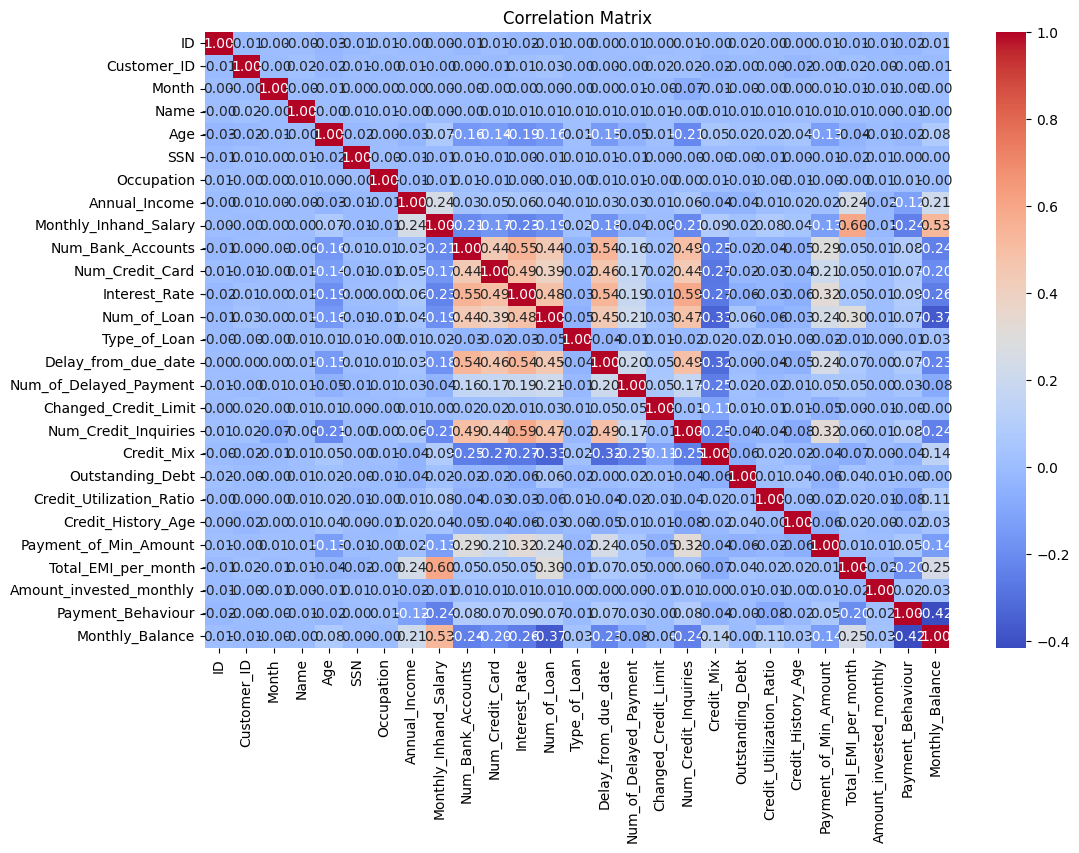

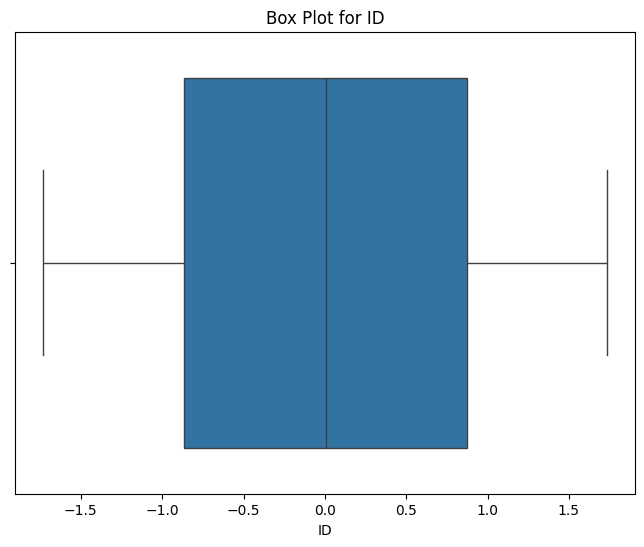

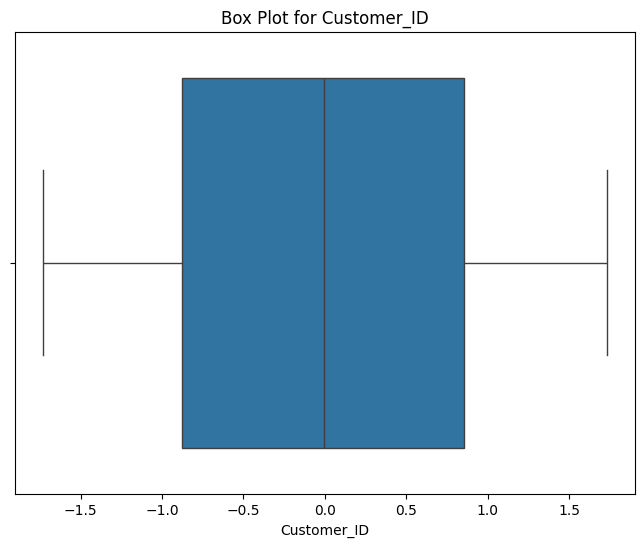

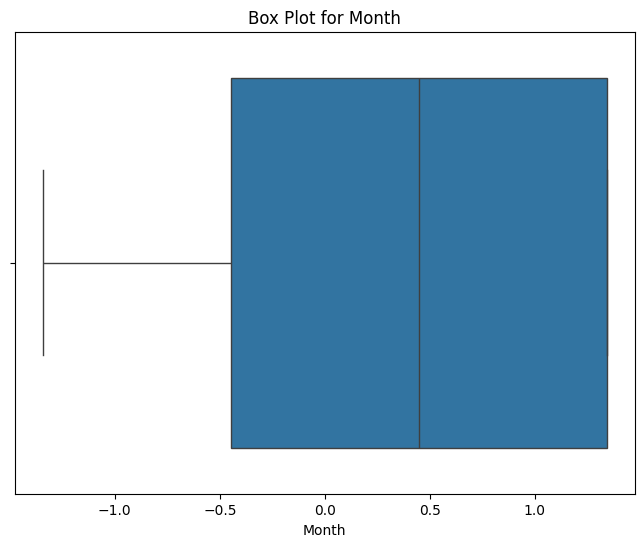

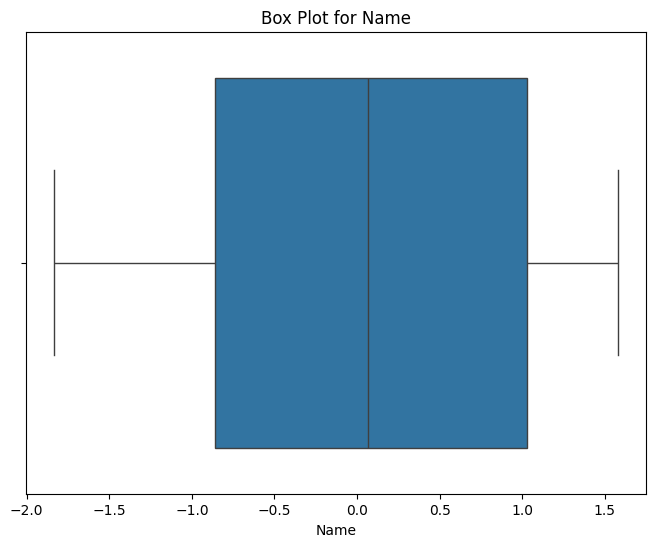

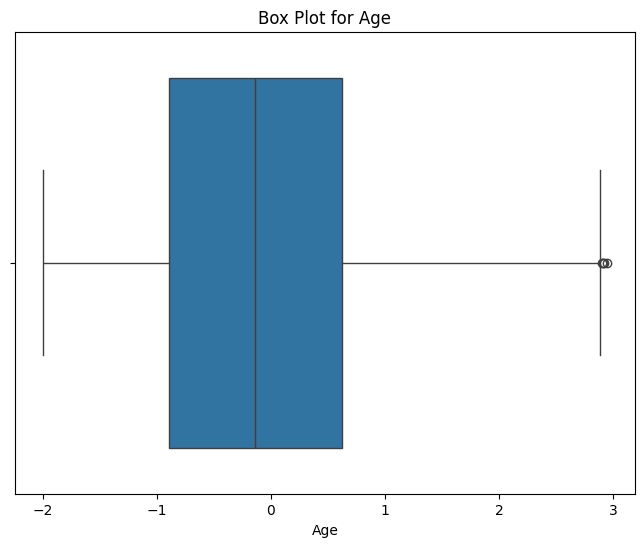

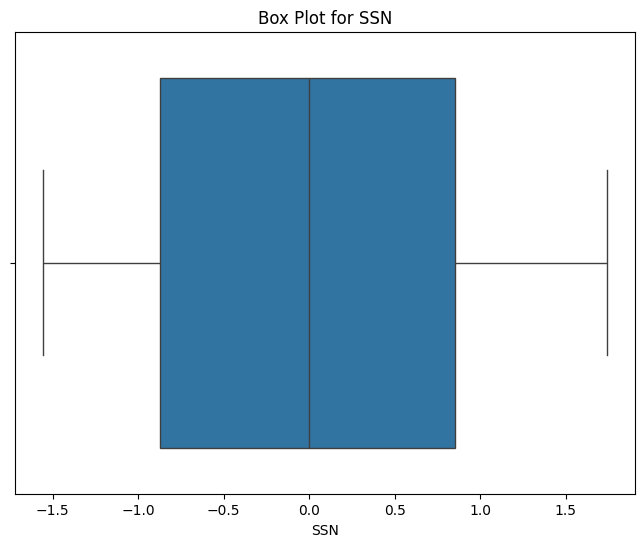

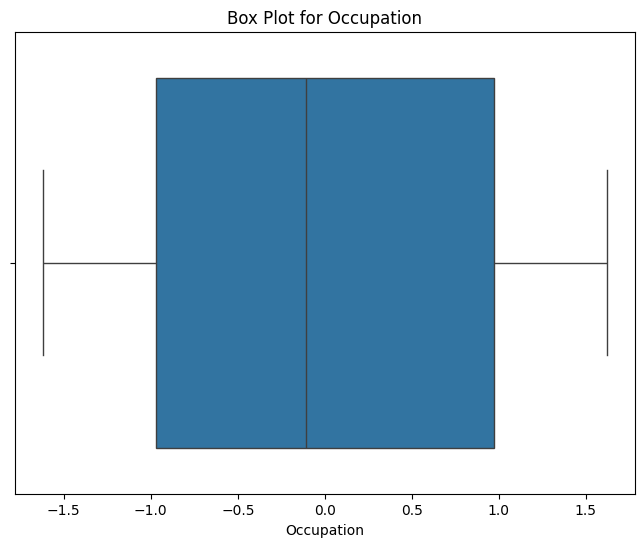

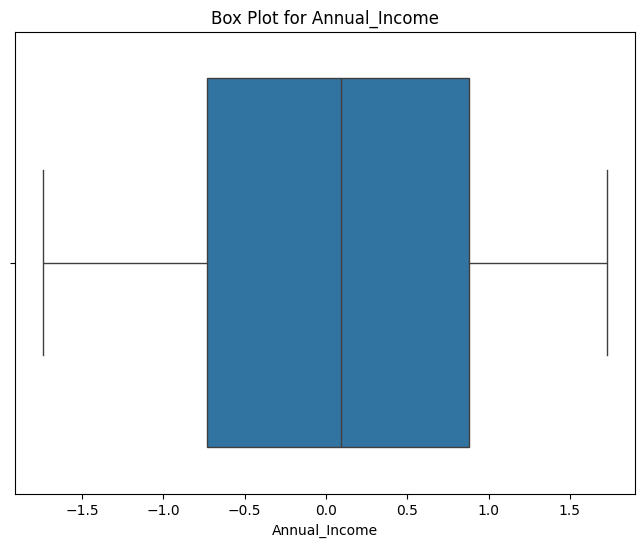

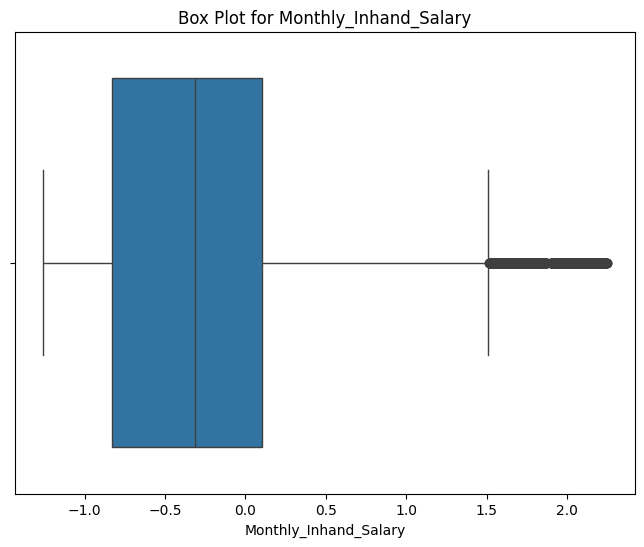

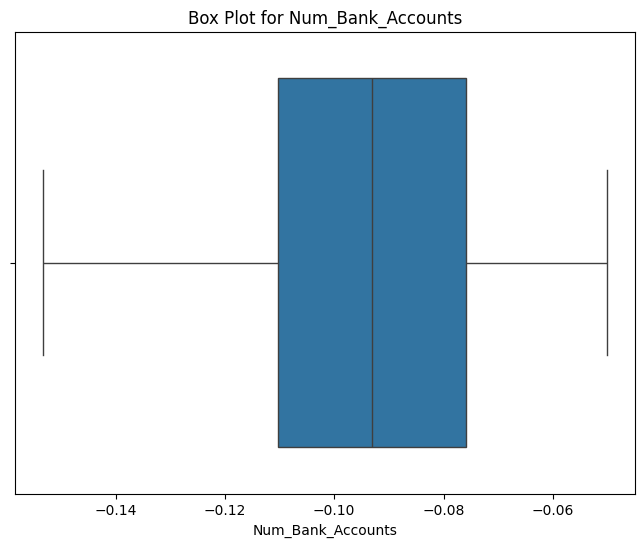

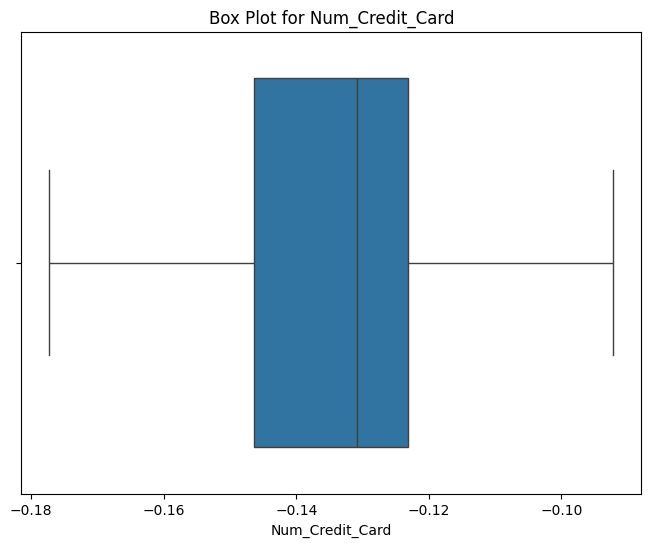

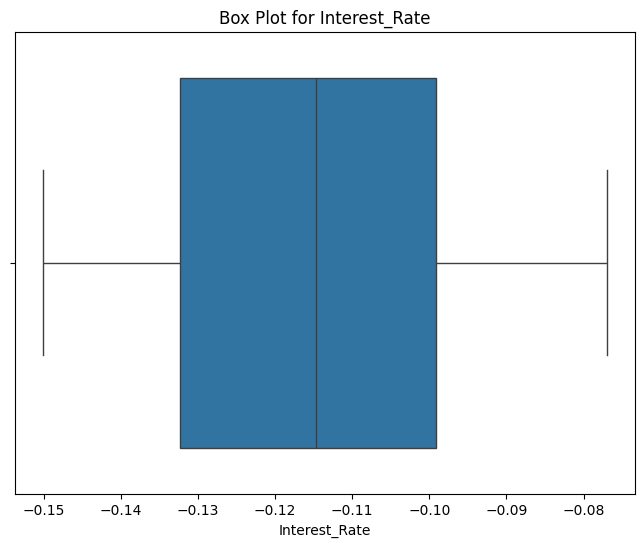

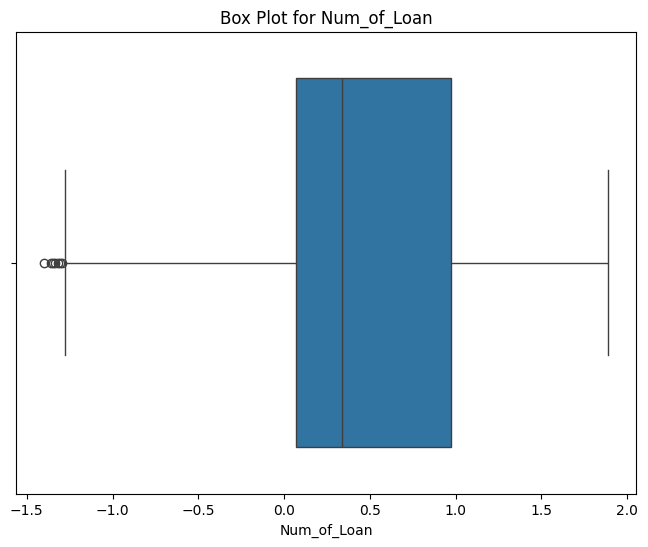

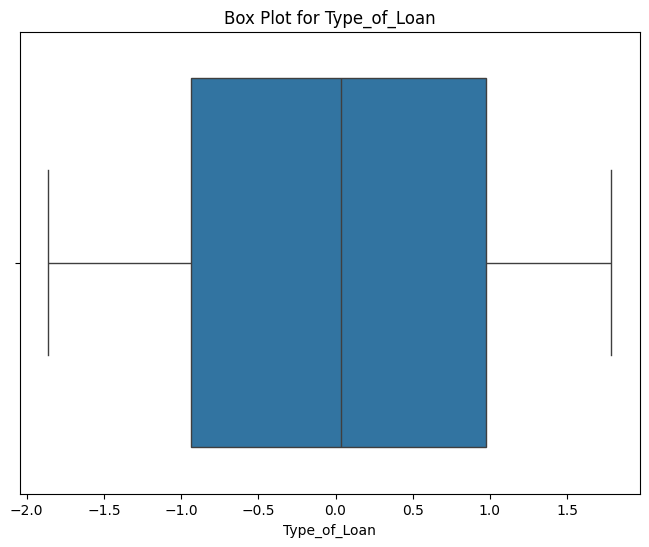

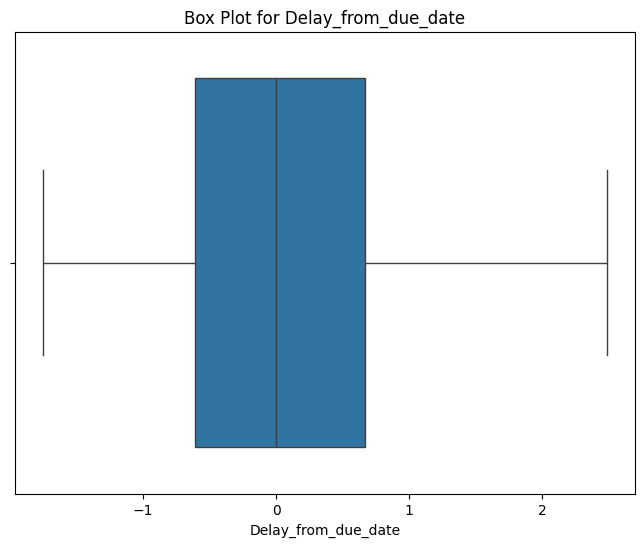

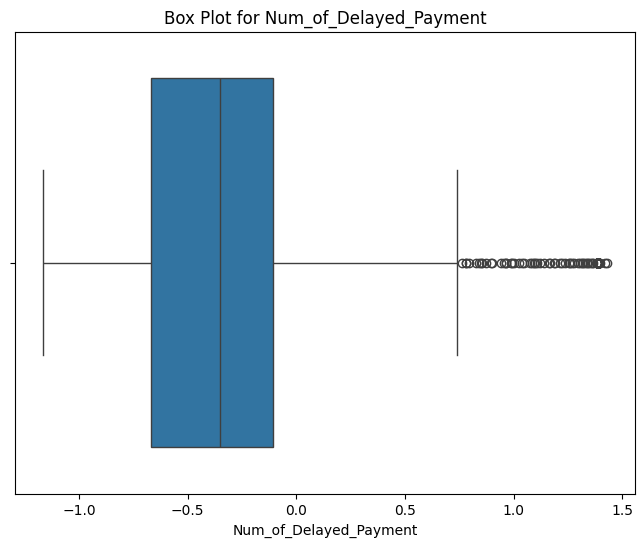

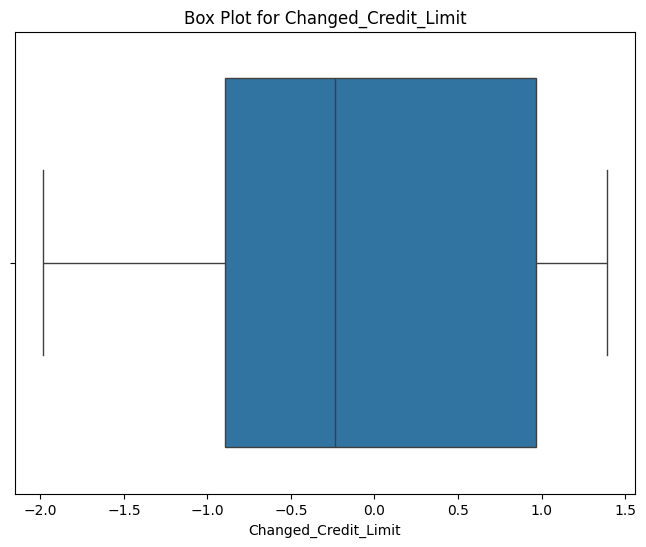

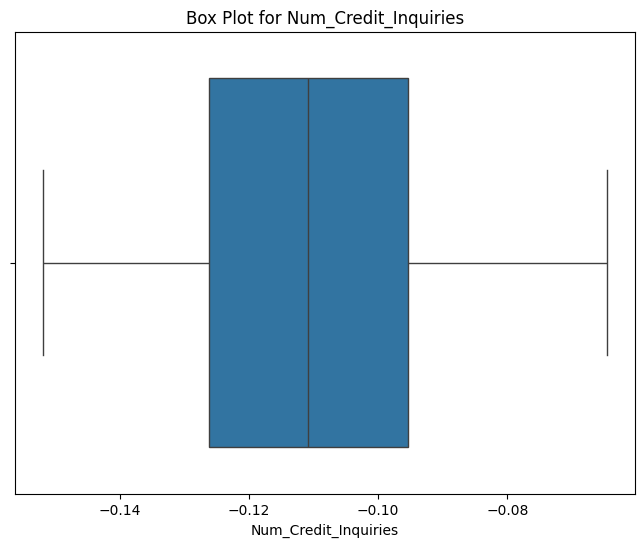

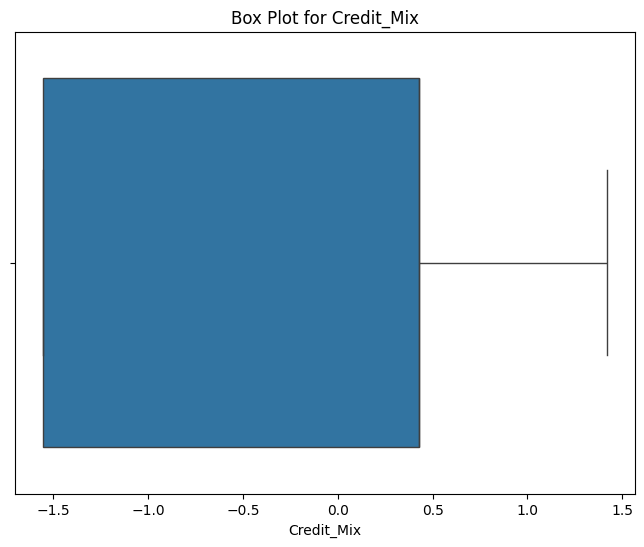

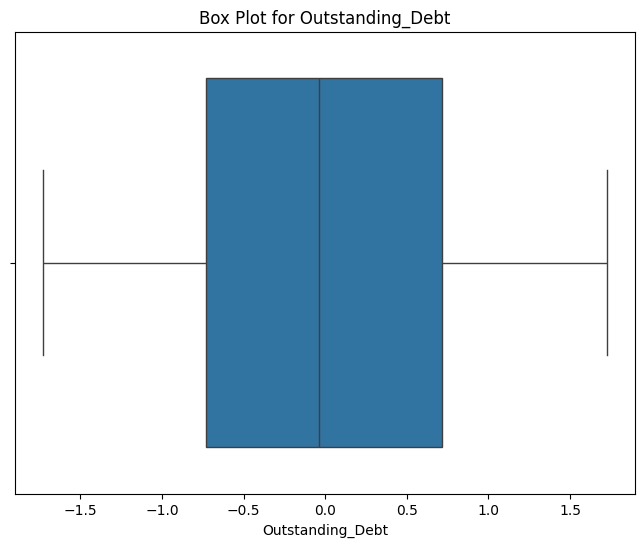

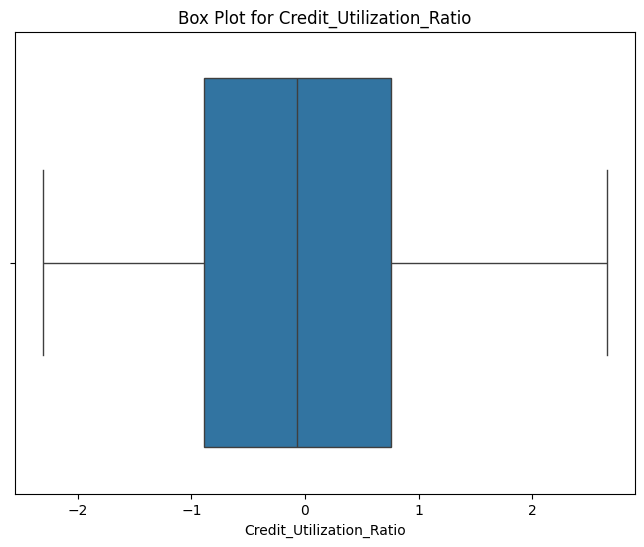

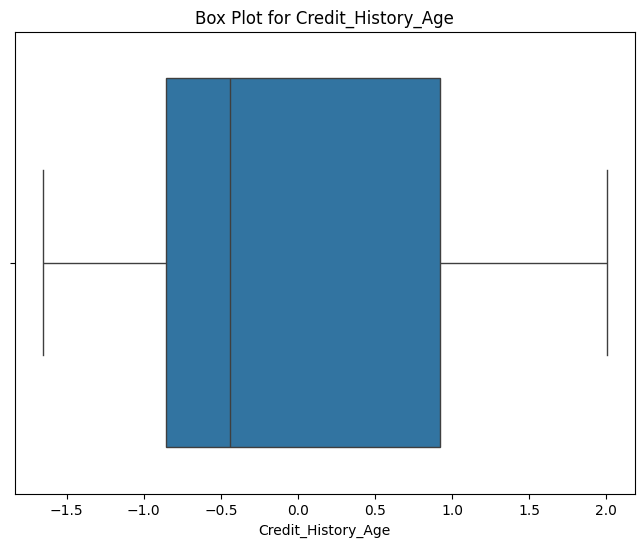

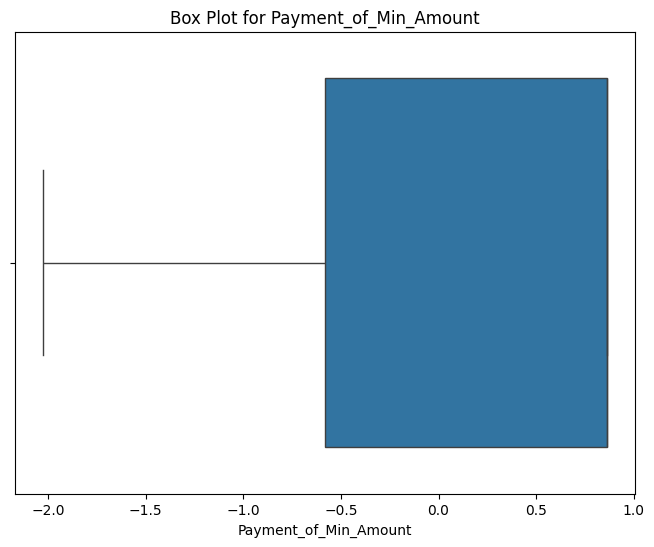

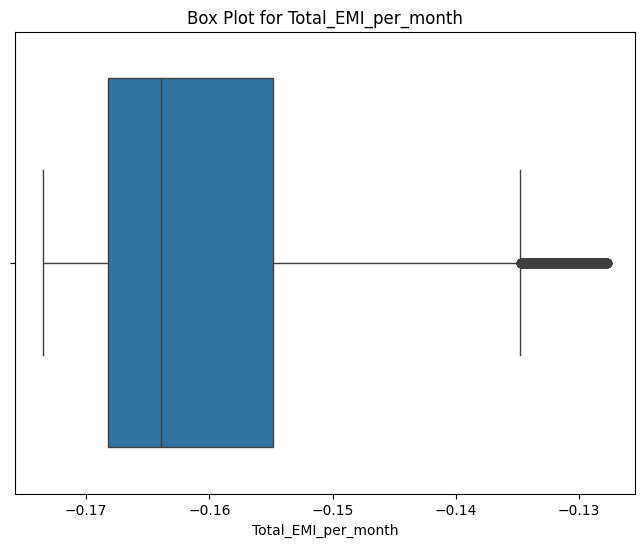

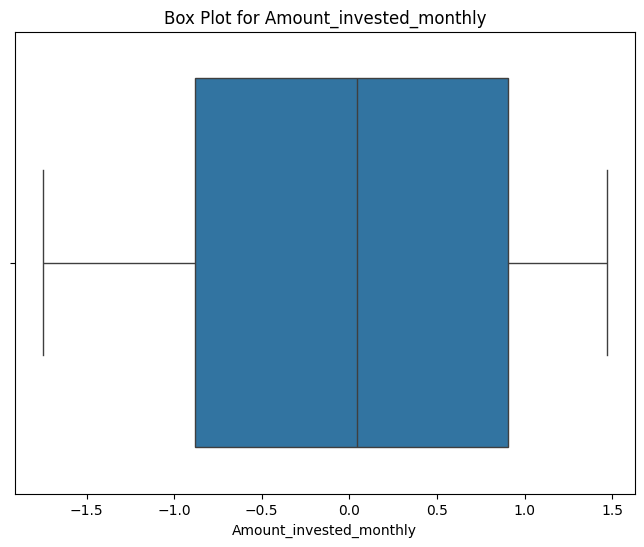

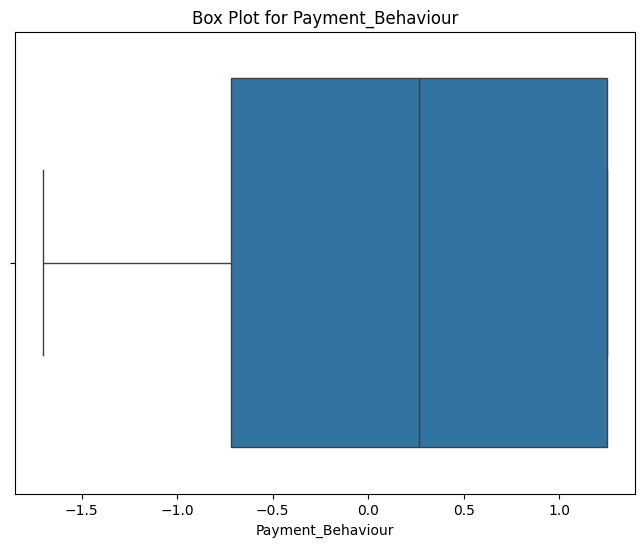

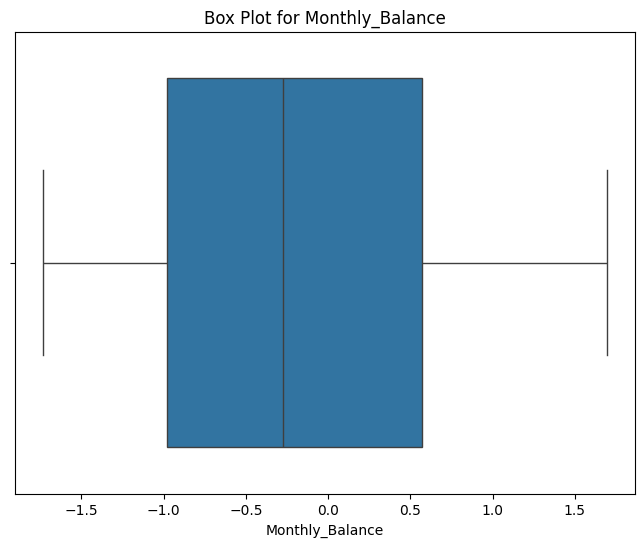

In [5]:
# 2. Exploratory Data Analysis

# Descriptive statistics
print("Descriptive Statistics:")
print(df.describe())

# Correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

# Boxplot for numerical features
for col in numeric_cols:
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=df, x=col)
    plt.title(f"Box Plot for {col}")
    plt.show()

## 3. Model Building
- Train multiple machine learning models using the preprocessed data.
- Evaluate the suitability of various models for the task.


In [6]:
# 3. Model Building

# Define features and target
X = df.drop(columns=['Credit_Mix'])  # Replace with your actual target column
y = df['Credit_Mix']

# Encode target variable
le_target = LabelEncoder()
y = le_target.fit_transform(y)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize models
model_lr = LogisticRegression()
model_rf = RandomForestClassifier()
model_svc = SVC(probability=True)

# Train models
model_lr.fit(X_train, y_train)
model_rf.fit(X_train, y_train)
model_svc.fit(X_train, y_train)

# Evaluate models
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    return {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, average='weighted'),
        "Recall": recall_score(y_test, y_pred, average='weighted'),
        "F1-Score": f1_score(y_test, y_pred, average='weighted')
    }

results = {
    "Logistic Regression": evaluate_model(model_lr, X_test, y_test),
    "Random Forest": evaluate_model(model_rf, X_test, y_test),
    "SVC": evaluate_model(model_svc, X_test, y_test)
}

print("Model Evaluation:")
for model_name, metrics in results.items():
    print(f"\n{model_name}:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")

Model Evaluation:

Logistic Regression:
Accuracy: 0.6660
Precision: 0.5685
Recall: 0.6660
F1-Score: 0.5995

Random Forest:
Accuracy: 0.7621
Precision: 0.6608
Recall: 0.7621
F1-Score: 0.6942

SVC:
Accuracy: 0.6807
Precision: 0.5463
Recall: 0.6807
F1-Score: 0.6060


## 4. Model Evaluation
- Compute and plot evaluation metrics for all models, such as accuracy, precision, recall, F1-score, and AUC-ROC.
- Compare the performance of models across multiple metrics.


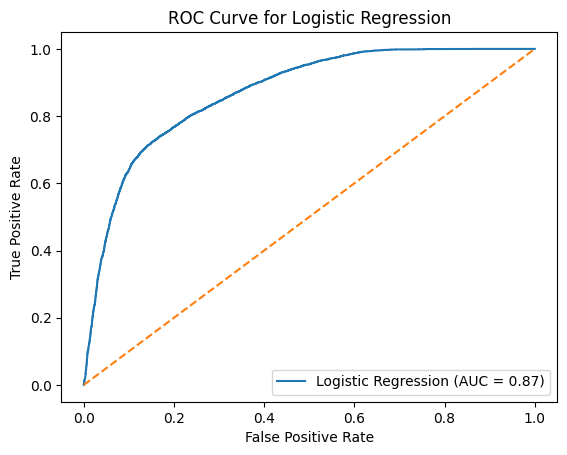

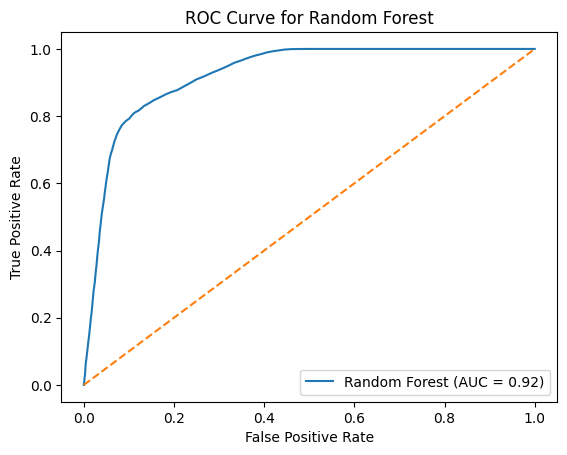

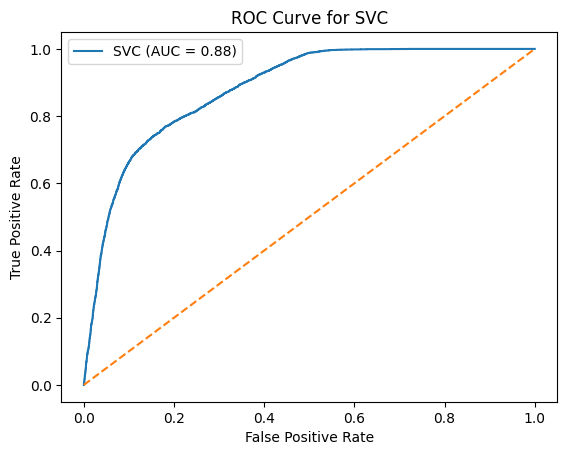

In [7]:
# 4. Model Evaluation and AUC-ROC

lb = LabelBinarizer()
y_test_bin = lb.fit_transform(y_test)

for model, model_name in zip([model_lr, model_rf, model_svc], ['Logistic Regression', 'Random Forest', 'SVC']):
    y_prob = model.predict_proba(X_test)
    fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_prob.ravel())
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {model_name}')
    plt.legend()
    plt.show()

## 5. Hyperparameter Tuning
- Optimize hyperparameters for each model using systematic search methods.
- Identify the best configuration for improved performance.


In [8]:
# 5. Hyperparameter Tuning

param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}
grid_search_rf = GridSearchCV(RandomForestClassifier(), param_grid_rf, cv=5, scoring='accuracy')
grid_search_rf.fit(X_train, y_train)
print("Best Parameters for Random Forest:", grid_search_rf.best_params_)

Best Parameters for Random Forest: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 300}


## 6. Retrain Models
- Retrain all models using the optimal hyperparameters on the training data.
- Validate the models on unseen data to ensure robustness.

In [9]:
# Retrain with best parameters
best_rf = grid_search_rf.best_estimator_
best_rf.fit(X_train, y_train)

RandomForestClassifier(min_samples_split=10, n_estimators=300)

## 7. Final Performance and Cross-Validation
- Evaluate the final performance of each model using cross-validation scores.
- Compare results to select the best-performing model.


In [10]:
# Cross-validation scores
cv_scores = cross_val_score(best_rf, X, y, cv=5)
print(f"Cross-Validation Scores for Random Forest: {cv_scores}")
print(f"Mean CV Score: {cv_scores.mean():.4f}")

# 6. Final Performance
final_metrics = evaluate_model(best_rf, X_test, y_test)
print("\nFinal Performance of Best Random Forest Model:")
for metric, value in final_metrics.items():
    print(f"{metric}: {value:.4f}")


Cross-Validation Scores for Random Forest: [0.74621065 0.70034979 0.62611737 0.74038088 0.74246842]
Mean CV Score: 0.7111

Final Performance of Best Random Forest Model:
Accuracy: 0.7682
Precision: 0.6523
Recall: 0.7682
F1-Score: 0.6893


## 8. Suggestions
- Provide recommendations based on the model insights and analysis.
- Suggest actionable steps to improve outcomes or address any gaps identified during the project.


In [11]:
def provide_recommendations():
    print("\nRecommendations and Next Steps:")
    print("- Focus on Random Forest for deployment due to its robust performance.")
    print("- Increase dataset size and perform advanced feature engineering.")
    print("- Experiment with ensemble methods like stacking or advanced algorithms such as XGBoost.")
    print("- Automate the preprocessing and model training pipeline using sklearn’s Pipeline.")
    print("- Monitor the deployed model’s performance and retrain periodically with new data.")
    print("- Leverage AUC-ROC metrics to continuously evaluate the model’s effectiveness.")
    
    print("\nSuggestions for Business/Application Use:")
    print("- Use the model predictions to make data-driven decisions.")
    print("- Implement a feedback loop to improve data quality over time.")
    print("- Consider integrating the model into a real-time system for ongoing analysis.")

provide_recommendations()



Recommendations and Next Steps:
- Focus on Random Forest for deployment due to its robust performance.
- Increase dataset size and perform advanced feature engineering.
- Experiment with ensemble methods like stacking or advanced algorithms such as XGBoost.
- Automate the preprocessing and model training pipeline using sklearn’s Pipeline.
- Monitor the deployed model’s performance and retrain periodically with new data.
- Leverage AUC-ROC metrics to continuously evaluate the model’s effectiveness.

Suggestions for Business/Application Use:
- Use the model predictions to make data-driven decisions.
- Implement a feedback loop to improve data quality over time.
- Consider integrating the model into a real-time system for ongoing analysis.
